# Purpose of this simulation


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tables
import aopy

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('talk')

# ideas

In [2]:
#for comparision
#data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'

N_RUNS = 10
 
data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/neurons_128/run_4/'

percent_high_SNR_noises = [0.7]

exp_conds_add = [f'iter_{s}_{i}' for s in percent_high_SNR_noises for i in range(N_RUNS)]
exp_conds_keep = [f'same_{s}_{i}' for s in percent_high_SNR_noises for i in range(N_RUNS)]
exp_conds = [f'wo_FS_{s}_{i}' for s in percent_high_SNR_noises for i in range(N_RUNS)]

exp_conds.extend(exp_conds_add)
exp_conds.extend(exp_conds_keep)


for e in exp_conds: print(e)

wo_FS_0.7_0
wo_FS_0.7_1
wo_FS_0.7_2
wo_FS_0.7_3
wo_FS_0.7_4
wo_FS_0.7_5
wo_FS_0.7_6
wo_FS_0.7_7
wo_FS_0.7_8
wo_FS_0.7_9
iter_0.7_0
iter_0.7_1
iter_0.7_2
iter_0.7_3
iter_0.7_4
iter_0.7_5
iter_0.7_6
iter_0.7_7
iter_0.7_8
iter_0.7_9
same_0.7_0
same_0.7_1
same_0.7_2
same_0.7_3
same_0.7_4
same_0.7_5
same_0.7_6
same_0.7_7
same_0.7_8
same_0.7_9


# Preproc the feature files

In [3]:
import aopy
import tables
import os

def load_feature_selection_files(data_dump_folder, exp_conds):
    """
    load feature selection from data dump folder
    
    Args;
    
    Returns:
        exp_data_all: a list of exp_data as parsed by bmi3d
        exp_data_metadata_all: a list of exp_metadata as parsed by bmi3d
    """

    exp_data_all = list()
    exp_data_metadata_all = list()

    for e in exp_conds:
        files = {'hdf':e+'.h5'}
        file_name = files['hdf']
        
        try:
            d,m = aopy.preproc.parse_bmi3d(data_dump_folder, files)

            #also load the clda and feature selection files

            feature_selection_data = aopy.data.load_hdf_group(data_dump_folder, file_name,'feature_selection')
            d['feature_selection'] =  feature_selection_data
            
            exp_data_all.append(d)
            exp_data_metadata_all.append(m)
            
        except:
            print(f'cannot parse {e}')

        
    return (exp_data_all, exp_data_metadata_all)

In [4]:
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)


In [5]:
exp_data_all = np.asarray(exp_data_all, dtype = 'object')
exp_metadata_all = np.asarray(exp_metadata_all, dtype = 'object')

#reshape them according to the exp conditions. 
#should be num by type and num by repetitions
exp_data_all_reshaped = exp_data_all.reshape((3, -1))
exp_metadata_all_reshaped = exp_metadata_all.reshape((3, -1))

exp_data_all.shape, exp_metadata_all.shape, exp_data_all_reshaped.shape, exp_metadata_all_reshaped.shape

((30,), (30,), (3, 10), (3, 10))

In [6]:
no_noise_neuron_ind = exp_data_all[0]['feature_selection']['no_noise_neuron_ind']
noise_neuron_ind = exp_data_all[0]['feature_selection']['noise_neuron_ind']

no_noise_neuron_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

# Check feature selection strategies

## display the strategies

In [7]:
def plot_feature_selection(active_feat_set_list, ax = None):
    """
    plot the selection strategy map. 
    """
    from matplotlib import colors
    
    
        
    active_feat_heat_map = np.array(active_feat_set_list, dtype = np.int32)
    active_feat_heat_map = np.ma.masked_where(active_feat_heat_map == False, active_feat_heat_map)
    

    
    if ax is None: 
        fig, ax = plt.subplots()
        print(type(ax))
        
        #color true to yellow
    cmap = colors.ListedColormap(['yellow'])
    ax.imshow(active_feat_heat_map.T, cmap = cmap)

   
    cmap.set_bad(color='blue')

    ax.set_xlabel('Learner batch')
    ax.set_ylabel('Feature index')





## check between conditions

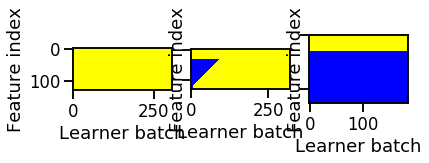

In [8]:
fig_feat_activity, ax_feat_activity = plt.subplots(1, 3, 
                                                   sharey = True)


for e, a in zip(exp_data_all_reshaped[:,1],  ax_feat_activity):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    

# check across rows

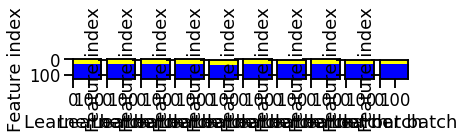

In [9]:
fig_feat_activity, ax_feat_activity = plt.subplots(1, 10, 
                                                   sharey = True)


for e, a in zip(exp_data_all_reshaped[2,:],  ax_feat_activity):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    


# Behaviour comparision

## count how many rewards

In [29]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((3,-1))
window_stamps_all = window_stamps_all.reshape((3,-1))

In [43]:
exp_data_all[0]['events']['time'][-10:]




masked_array(data=[181574, 181674, 181687, 181688, 181776, 181788, 181789,
                   181860, 181873, 181874],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=999999,
            dtype=uint64)

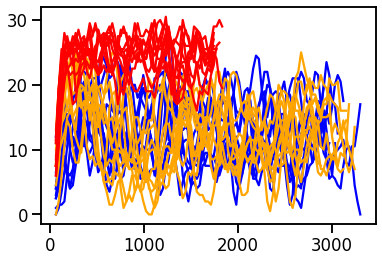

In [30]:
colors = ['blue', 'orange', 'red']


for r,w,c in zip(reward_rate_all, window_stamps_all,colors):
    for ww, rr in zip(w,r):
        plt.plot(ww, rr, color = c)

## Trial segments and trajectories

In [46]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

import functools

def get_all_cursor_trajectories(exp_data_all, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    cursor_trajectories_list = list()
        
    for e in exp_data_all:
        (cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(e, start_code = start_code, end_codes=end_codes)
        cursor_trajectories_list.append(cursor_trajectories)

    
    return cursor_trajectories_list

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, start_code,  end_codes)
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [47]:
start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)


range(17, 24)


In [48]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)


#calc_trial_times(trial_times)

In [49]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

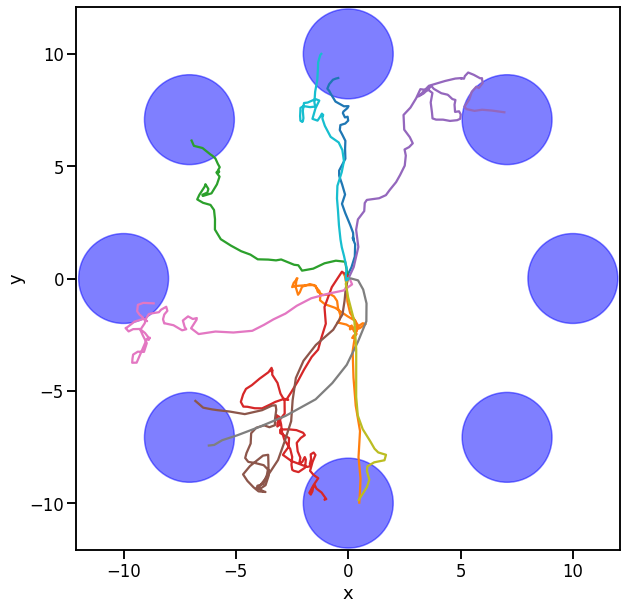

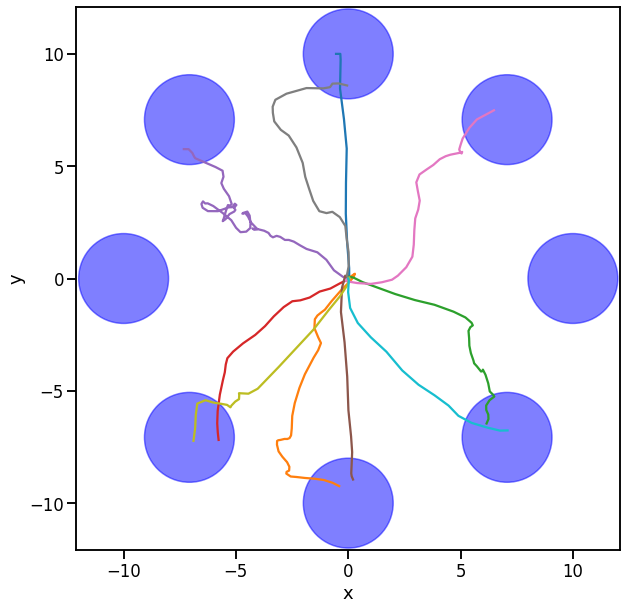

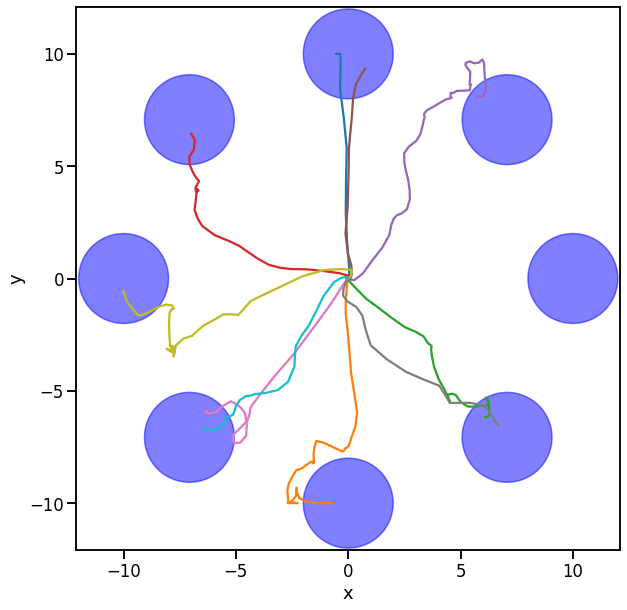

In [76]:
cursor_trajectories_list = np.array(cursor_trajectories_list).reshape(3, -1)



for c in cursor_trajectories_list[:,2]:
    plot_cursor_trajectories(c[:10], exp_data_all[0], exp_metadata_all[0])

# Post data analysis

# Behaviour  analyses

## Trajectory analysis

In [44]:
def calculate_traj_length(trajectories):
    """
    given a list of trajectories, calculate each trajectory's length
    
    args:
        trajectories[np.ndarray]: number of data points by number of dims
    """
    traj_length = np.empty((len(trajectories)))
    
    for i,t in enumerate(trajectories):
        delta = np.diff(t, axis = 0)
        
        
        delta_length = delta**2
        
        
        delta_sum = np.sum(delta_length, axis = 1) ** (1/2)
        
        delta_sum = np.sum(delta_sum)
        
        traj_length[i] = delta_sum
        
    return traj_length
        
        

def test_calculate_traj_length():
    
    
    #test a line segment length
    cursor_trajectory = np.arange(0,1, 0.1).reshape(-1,1)
    expected_trajectory_length = np.array([0.9])
    calculated_trajectory_length = calculate_traj_length([cursor_trajectory])
    
    np.testing.assert_array_equal(expected_trajectory_length, calculated_trajectory_length)
    
    
test_calculate_traj_length()    

30
(10,)
(10,)
(10,)


Text(0.5, 0, 'Trial #')

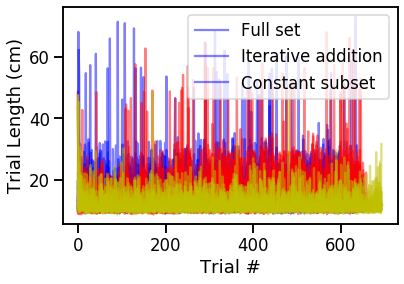

In [54]:


cursor_length = [calculate_traj_length(t) for t in cursor_trajectories_list]

cursor_length_array = np.asarray(cursor_length).reshape(3, N_RUNS)

colors =  ['b','r', 'y']

print(len(cursor_length))
for t,c in zip(cursor_length_array, colors):
    print(t.shape)
    for l in t:
        plt.plot(l, color = c, alpha = 0.5)

plt.legend(['Full set','Iterative addition', 'Constant subset'])
plt.ylabel('Trial Length (cm)')

plt.xlabel('Trial #')

## Variance analysis

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

## decoder

In [55]:
exp_data_all[0]['feature_selection'].keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'n_starting_feats', 'n_states', 'no_noise_neuron_ind', 'noise_mode', 'noise_neuron_ind', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

(300, 128, 7)


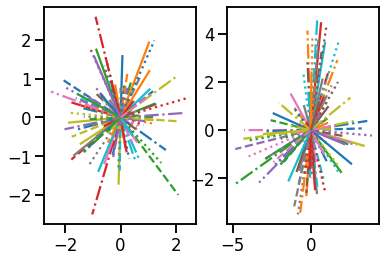

In [56]:
from afs_plotting import plot_prefered_directions

C_mat = exp_data_all[2]['feature_selection']['C_mat']

print(C_mat.shape)



fig, ax = plt.subplots(1,2)

plot_prefered_directions(C_mat[0], ax = ax[0])
plot_prefered_directions(C_mat[-1], ax = ax[1])

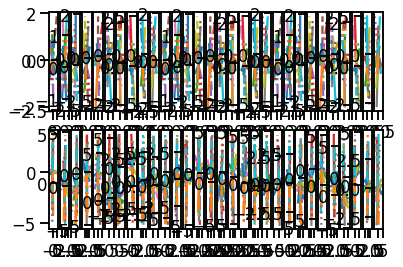

In [57]:
from afs_plotting import plot_prefered_directions

def plot_all_initial_C_mat(exp_data_all, selected_neuron = 'all',debug = True):
    
    """
    just compare initial C mat with the last C_mat
    """
    
    N_EXP = len(exp_data_all)
    
    fig, ax = plt.subplots(2, N_EXP)
    
    for i in range(N_EXP):
        C_mat = exp_data_all[i]['feature_selection']['C_mat']
        plot_prefered_directions(C_mat[0][no_noise_neuron_ind,:], ax = ax[0,i])
        plot_prefered_directions(C_mat[-1][no_noise_neuron_ind,:], ax = ax[1,i])
        

plot_all_initial_C_mat(exp_data_all)


## Decoder compared to the encoder



In [ ]:
exp_data_all[0].keys()

In [ ]:
exp_data_all.shape

In [62]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

active_angles_list = list()

least_num_updates = 180

for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['C_mat']
    
    angles_hist = calc_cosine_to_target_matrix(dec_directions, enc_directions)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    active_angles_list.append(active_angles[:least_num_updates])


(3, 180)


<Figure size 432x288 with 0 Axes>

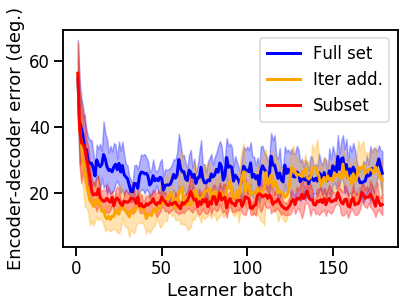

In [71]:

active_angles_list = np.array(active_angles_list) 


active_angles_list_reshape = active_angles_list.reshape((3,N_RUNS,-1))

active_angles_std = np.std(active_angles_list_reshape, axis = 1)
active_angles_mean =  np.mean(active_angles_list_reshape, axis = 1)


plt.figure()

batch_num = np.arange(active_angles_mean.shape[1])


colors = ['blue', 'orange', 'red'] 

print(active_angles_mean.shape)

fig_C, ax_C = plt.subplots()



for i,c in enumerate(colors):

    plt.plot(active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)

plt.xlabel('Learner batch')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

## batch update 

In [ ]:
import sympy as sp

intended_kin = clda_log['intended_kin']
spike_counts_batch = clda_log['spike_counts_batch']
kf_C = clda_log['kf_C']

i =  0

# fit the batch data

from riglib.bmi.kfdecoder import KalmanFilter

feature_selection_data = exp_data_all[0]['feature_selection']
sim_C = feature_selection_data['sim_C']

def train_C_mat_on_batch_data(intended_kin, spike_counts_batch):

    C_hat_list = list()
    
    num_times =  intended_kin.shape[0]
    
    for i  in range(num_times):

        k = intended_kin[i, :,:]
        s = spike_counts_batch[i,:,:]

        C,Q = KalmanFilter.MLE_obs_model(k, s, include_offset=False, drives_obs=[3,5])

        C_hat_list.append(C)



    C_hat_list = np.array(C_hat_list)
    
    return C_hat_list
    
    
    
for i in range(9): 
    clda_log = exp_data_all[i]['bmi3d_clda']
    intended_kin = clda_log['intended_kin']
    spike_counts_batch = clda_log['spike_counts_batch']
    print(clda_log.shape)
    
#     C_hat_list = train_C_mat_on_batch_data(intended_kin, spike_counts_batch)
    
#     print(C_hat_list.shape)
#     C_hat_mean = np.mean(C_hat_list, axis = 0)
#     angles = calc_cosine_sim_bet_two_matrices(C_hat_mean, sim_C)

    
    #plt.plot(angles)





In [ ]:
np.sum(exp_data_all[1]['bmi3d_task']['update_bmi'])


## looking at K matrix

In [ ]:
NUM_EXP = 3
GLOBAL_FIGURE_VERTICAL_SIZE  = 4

figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))
exp_data_all_reshaped = exp_data_all.reshape(3, N_RUNS)


#compare the K matrix before the exp
for i in range(NUM_EXP):
    K_mat = exp_data_all_reshaped[0,i]['feature_selection']['K_mat']
    K = K_mat[1].T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i], plot_states = [0,2])
    axes_k_matrix[0, i].set_title(exp_conds[i])

#compare to the matrix after the exp
for i in range(3):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    
    K = K_mat[-1].T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i], plot_states = [0,2])
    axes_k_matrix[1,i].set_title(exp_conds[i])
figure_k_matrix.tight_layout()

In [ ]:



def plot_state_bar(K:np.ndarray, ax =  None, fig = fig, state_names = None):
    """
    K [np.array]: a state variable that records the state
    """
    
    num_state, num_var = K.shape
    
    if num_state >= num_var: print(f'Number of states {num_state} is greater than the {num_var} \n is this intended?')
        
    if ax is None: fig, ax = plt.subplots(2, 3, figsize = (12, 8),sharex =  True)
        
    var_pos = np.arange(num_var)
    
    for i in range(3):
        ax[0, i].bar(var_pos, K[i,:])
        ax[1,i].bar(var_pos, K[i + 3,:])
        
        
        
    fig.tight_layout()
    
    return ax


fig, ax = plt.subplots(2,3, figsize = (12,8))


for i in range(len(exp_data_all)):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    K = K_mat[-1]

    plot_state_bar(abs(K), ax = ax, fig = fig)

In [64]:
active_feat_set = feature_selection_data['feat_set']
active_feat_set_last = active_feat_set[0]
active_angles_list = list()

least_num_updates = 180

for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['K_mat']

    dec_directions = np.moveaxis(dec_directions, 2,1)   
    

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    

    active_angles_list.append(active_angles[:least_num_updates])


/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(3, 180)


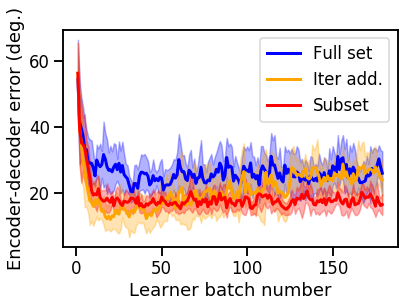

In [72]:

active_angles_list = np.array(active_angles_list)
active_angles_list = active_angles_list.reshape((3,N_RUNS,-1))

active_angles_mean = np.mean(active_angles_list, axis = 1)
active_angles_std = np.std(active_angles_list, axis = 1)

colors = ['blue', 'orange', 'red'] 

print(active_angles_mean.shape)

fig_C, ax_C = plt.subplots()



for i,c in enumerate(colors):

    plt.plot(active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)


plt.xlabel('Learner batch number')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

(3, 180)


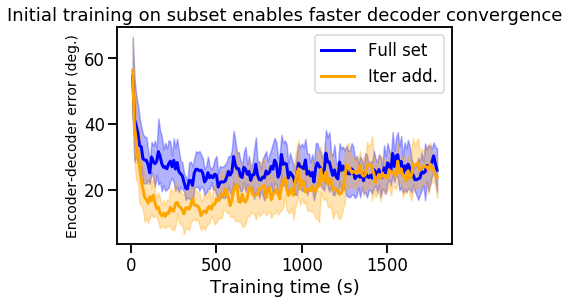

In [73]:


fig_C, ax_C = plt.subplots()


colors = ['blue', 'orange'] 

batch_num = np.arange(least_num_updates) * 10

print(active_angles_mean.shape)

for i,c in enumerate(colors):

    plt.plot(batch_num, active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)

plt.title('Initial training on subset enables faster decoder convergence')
plt.xlabel('Training time (s)')
plt.ylabel('Encoder-decoder error (deg.)', fontsize = 14)
plt.legend(['Full set', 'Iter add.'])

In [ ]:
# examine the features after the first update.

def find_K_gain(index:int, update_period: float, fps = 60):
    """
    find the latest Kalman gain
    """
    update_frame_count = int(update_period * fps)
    
    return int(index // update_frame_count)
    
def test_find_K_gain():
    
    assert 0 == find_K_gain(598, 10, 60)
    assert 1 == find_K_gain(1198, 10, 60)

test_find_K_gain()

In [ ]:
update_time = 600

spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']
spike_counts = np.squeeze(spike_counts)

spike_counts_single_time = spike_counts[update_time, :]

target_state  = exp_data_all[0]['bmi3d_task']['target_state']
target_state_time = target_state[update_time, :]


num_K = find_K_gain(update_time, update_period = 10)
K_mat_time = K_mat[num_K]

feature_state_update = K_mat_time @  np.diag(spike_counts_single_time)


target_state_time_rep = np.tile(target_state_time, len(spike_counts_single_time))


useful_update = feature_state_update * target_state_time_rep
useful_update = np.sum(useful_update, axis = 0)


plt.plot(useful_update)


In [ ]:
intended_kin = exp_data_all[0]['bmi3d_clda']['intended_kin']

spike_counts_batch = exp_data_all[0]['bmi3d_clda']['spike_counts_batch']
spike_counts_batch =  np.swapaxes(spike_counts_batch, 2, 1)

intended_kin = np.swapaxes(intended_kin, 2, 1)

spike_counts_batch.shape

In [ ]:
print(intended_kin.shape)

intended_kin_one = intended_kin[1, 1, :]
print(intended_kin_one)

## Q mat

In [ ]:
feature_selection_data.keys()

In [ ]:
fig_Q, axes_Q = plt.subplots(1,2, sharey = True)

num_noises = 1

from afs_plotting import get_cmap
import matplotlib as mpl

cmap_q = get_cmap(num_noises)

cmap_q_1 = get_cmap(num_noises, mpl.cm.Oranges)

cmap_q_2 = get_cmap(num_noises, mpl.cm.Reds)

for i in range(num_noises):
    
    for j in range(3):


        Q_list = np.array(exp_data_all[j]["feature_selection"]['Q_diag'])



        Q_diag_no_noise = np.mean(Q_list[:, no_noise_neuron_ind], axis = 1)

        Q_diag_noise = np.mean(Q_list[:, noise_neuron_ind], axis = 1)



        axes_Q[0].plot(Q_diag_noise)

        axes_Q[1].plot(Q_diag_no_noise)

    

axes_Q[0].set_xlabel('Time (s)')

axes_Q[1].set_xlabel('Time (s)')



axes_Q[0].set_title('Low SNR neurons')

axes_Q[1].set_title('High SNR neurons')



# Feature analysis

In [ ]:
decoder_state = exp_data_all[0]['bmi3d_task']['decoder_state']
target_state = exp_data_all[0]['bmi3d_task']['target_state']
spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']


print(decoder_state.shape)
print(target_state.shape)
print(spike_counts.shape)

spike_counts = exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['feature_selection']['K_mat'].shape

In [ ]:
exp_data_all[0]['bmi3d_task']['update_bmi']

In [ ]:
np.argwhere((exp_data_all[0]['bmi3d_task']['update_bmi']))

## examine used C mat

In [ ]:
GLOBAL_FIGURE_VERTICAL_SIZE  =  10

fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list

for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C = enc_directions)


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
#axes_compr_means.set_title('Means of the high SNR weight trajectory')